# Assignment 1 - Word2Vec
1.  Try a real corpus (instead of banana apple, try something real... on the internet....) - not so big!  

Just you have a good taste of real stuff....like 50 documents, each have 50 words....

2. Try window size of 2

3. Try CBOW (instead of skipgrams)

4. Compare normal version of skipgrams vs. negative sampling version of skipgrams in terms of time (using real corpus)

In [1]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import pandas as pd
spacy.__version__

'3.4.2'

## 1 Load Data
A real corpus

In [2]:
nlp = spacy.load('./en_core_web_sm/')
text = open('./dataset/alchemist.txt',mode='r') #change later
df = pd.DataFrame(text.readlines())

### Clean Data

In [3]:
def clean_data(df_col):
    corpus = []
    for item in df_col:
        item = re.sub('[^A-Za-z0-9]+', ' ', str(item)) # remove special characters
        item = item.lower() # lower all characters
        item = item.split() # split data
        corpus.append(' '.join(str(x) for x in item))
    return corpus

In [4]:
#1. tokenize
#data cleaned
corpus = clean_data(df[0])
#data tokenized
corpus_tokenized = [sent.split(" ") for sent in corpus]

In [5]:
#2. numericalize (vocab)
#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized)))

#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

#adding unknown word
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

voc_size = len(vocabs)
voc_size

1233

In [6]:
#preparing all_vocabs
batch_size = 2

def prepare_seqeunce(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_seqeunce(list(vocabs),word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 1233])

### Testing Skipgram and CBOW

In [7]:
skipgrams = []
cbow = []
for sent in corpus_tokenized:
    #for each sent ('apple', 'banana', 'fruit')
    for i in range(2,len(sent)-2): #start from 2 to second last
        center_word = sent[i]
        outside_word = [sent[i-2],sent[i-1],sent[i+1],sent[i+2]] #window size = 2
        cbow.append((outside_word, center_word))
        for o in outside_word: 
            skipgrams.append((center_word,o))

In [8]:
skipgrams[:5]

[('crowning', 'high'),
 ('crowning', 'up'),
 ('crowning', 'the'),
 ('crowning', 'grassy'),
 ('the', 'up')]

In [9]:
cbow[:4]

[(['high', 'up', 'the', 'grassy'], 'crowning'),
 (['up', 'crowning', 'grassy', 'summit'], 'the'),
 (['crowning', 'the', 'summit', 'of'], 'grassy'),
 (['the', 'grassy', 'of', 'a'], 'summit')]

### Set random_batch

In [ ]:
    for sent in corpus_tokenized:
        for i in range(2,len(sent)-2): #start from 2 to second last
            center_word = word2index[sent[i]]
            outside_word = [word2index[sent[i-2]],word2index[sent[i-1]],word2index[sent[i+1]],word2index[sent[i+2]]] #window size = 2
            cbow.append((outside_word, center_word))

In [29]:
def random_batch(batch_size, corpus, window_size=1,architecture='skipgram'):
    skipgrams = []
    cbows = []
    outside_word_total = []
    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ('apple', 'banana', 'fruit')
        for i in range(window_size,len(sent)-window_size): #start from 2 to second last
            outside_word_total.append([])
            # print(sent[i])
            center_word = word2index[sent[i]]
            for j in range(window_size):
                outside_word = [word2index[sent[i-j]],word2index[sent[i+j]]] #window_size adjustable
                #here we want to create (banana, apple), (banana, fruit) append to some list
                for o in outside_word:
                    skipgrams.append([center_word,o])
                    outside_word_total[i-window_size].append(o)
            # print(outside_word_total)
            cbows.append((outside_word_total[i-window_size],center_word))
    
    if architecture == 'skipgram':
        arch = skipgrams
    else:
        arch = cbows
        
    #only get a batch, not the entire lsit
    random_index = np.random.choice(range(len(arch)),batch_size,replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [] , []
    for index in random_index:
        print(arch[index])
        random_inputs.append([arch[index][0]]) #center words, this will be as shape of (1,) -> (1,1) for modeling
        random_labels.append([arch[index][1]])

    return np.array(random_inputs),np.array(random_labels)

In [30]:
batch_size = 2 
input_batch, label_batch = random_batch(batch_size,corpus,window_size=2,architecture='cbow')
# input_batch = torch.LongTensor(input_batch)
# label_batch = torch.LongTensor(label_batch)
input_batch.shape,label_batch.shape

([509, 509, 276, 912, 933, 933, 277, 831, 509, 509, 505, 254, 221, 221, 887, 52, 836, 836, 1045, 540, 659, 659, 882, 840, 287, 287, 530, 963, 1226, 1226, 604, 738, 457, 457, 782, 144, 375, 375, 509, 1073, 1201, 1201, 1176, 887, 719, 719, 378, 461, 461, 461, 719, 229, 186, 186, 659, 865, 659, 659, 509, 724, 808, 808, 887, 1210, 240, 240, 147, 920, 428, 428, 396, 887, 232, 232, 753, 880, 461, 461, 136, 1056, 128, 128, 38, 29], 128)
([833, 833, 608, 887, 887, 887, 659, 136, 492, 492, 659, 1050, 768, 768, 426, 719, 198, 198, 10, 197, 659, 659, 340, 887, 887, 887, 214, 656, 380, 380, 155, 887, 197, 197, 1143, 715, 659, 659, 923, 887, 887, 887, 579, 605, 439, 439, 235, 1182, 1141, 1141, 1144, 511, 166, 166, 396, 887, 765, 765, 147, 162, 540, 540, 29, 1174, 887, 887, 833, 53], 540)


C:\Users\Guntsv\AppData\Local\Temp\ipykernel_24436\1257779157.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(random_inputs),np.array(random_labels)


((2, 1), (2, 1))

In [30]:
input_batch

array([[903],
       [518]])

In [51]:
label_batch

tensor([[ 85],
        [889]])

## 2.1 Continuous Bag-of-Words (CBOW)

In [27]:
def random_batch_cbow(batch_size, corpus, window_size=1):
    cbow = []
    for sent in corpus_tokenized:
        #for each sent ('apple', 'banana', 'fruit')
        for i in range(2,len(sent)-2): #start from 2 to second last
            center_word = word2index[sent[i]]
            outside_word = [word2index[sent[i-2]],word2index[sent[i-1]],word2index[sent[i+1]],word2index[sent[i+2]]] #window size = 2
            cbow.append((outside_word, center_word))
            # for o in outside_word: 
            #     skipgrams.append((center_word,o))

        batch_size = 2    
        #only get a batch, not the entire lsit
        random_index = np.random.choice(range(len(cbow)),batch_size,replace=False)
        
        #appending some list of inputs and labels
        random_inputs, random_labels = [] , []
        for index in random_index:
            random_inputs.append(cbow[index][0]) #center words, this will be as shape of (1,) -> (1,1) for modeling
            random_labels.append(cbow[index][1])
    return np.array(random_inputs),np.array(random_labels)

In [28]:
batch_size = 2 
input_batch, label_batch = random_batch_cbow(batch_size,corpus)
input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch).view(-1,1)
input_batch.shape,label_batch.shape

(torch.Size([2, 4]), torch.Size([2, 1]))

### CBOW Model

In [20]:
class CBOW(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(CBOW,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        # print(center_word_embed.shape,outside_word_embed.shape,all_vocabs_embed.shape)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar
        return loss_fn

In [21]:
batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = CBOW(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
input_batch, label_batch = random_batch_cbow(batch_size,corpus)
input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch).view(-1,1)
input_batch.shape,label_batch.shape,all_vocabs.shape

(torch.Size([2, 4]), torch.Size([2, 1]), torch.Size([2, 1233]))

### training

In [23]:
import time
num_epochs = 5000
#for epoch
start = time.time()
for epoch in range(num_epochs):
    
    #get random batch
    input_batch, label_batch = random_batch_cbow(batch_size,corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch).view(-1,1)

    # print(input_batch.shape,label_batch.shape,all_vocabs.shape)
    # break

    #loss = model
    loss = model(input_batch,label_batch,all_vocabs)
    
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()

    end = time.time()
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {end-start}")
    # break

Epoch: 1000 | cost: 9.490294 | time: 14.370651245117188
Epoch: 2000 | cost: 7.652987 | time: 28.046244621276855
Epoch: 3000 | cost: 8.939983 | time: 41.68855881690979
Epoch: 4000 | cost: 7.511162 | time: 55.846851110458374
Epoch: 5000 | cost: 9.134085 | time: 70.14501404762268


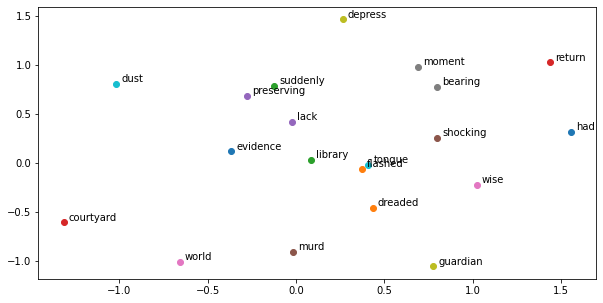

In [24]:
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()

#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(10,5))
for i, word in enumerate(vocabs[:20]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

# Compare normal version of skipgrams vs. negative sampling version of skipgrams in terms of time (using real corpus)

## 2.2 Skipgram

### Skipgram Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [11]:
class Skipgram(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        # print(center_word_embed.shape,outside_word_embed.shape,all_vocabs_embed.shape)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar
        return loss_fn

In [12]:
batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = Skipgram(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

### training

In [15]:
import time
num_epochs = 5000
#for epoch
start = time.time()
for epoch in range(num_epochs):
    
    #get random batch
    input_batch, label_batch = random_batch(batch_size,corpus,window_size=2)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)

    # print(input_batch.shape,label_batch.shape,all_vocabs.shape)
    # break

    #loss = model
    loss = model(input_batch,label_batch,all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()

    end = time.time()

    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {end-start}")

Epoch: 1000 | cost: 8.419220 | time: 32.79576086997986
Epoch: 2000 | cost: 5.376984 | time: 65.33333158493042
Epoch: 3000 | cost: 9.117195 | time: 99.61967253684998
Epoch: 4000 | cost: 10.492447 | time: 128.41247725486755
Epoch: 5000 | cost: 6.754722 | time: 157.3727912902832


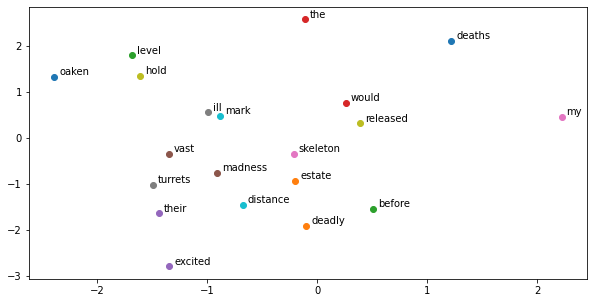

In [16]:
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()

#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(10,5))
for i, word in enumerate(vocabs[:20]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

## 2.3 Negative Sampling

### Unigram Distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [17]:
##Unigram Distribution
z = 0.0001
#count all the occurence of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
word_count

num_total_words = sum([c for w, c in word_count.items()])
num_total_words

unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha/z)
    # print('Vocab :',v)
    # print('distribution :', uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)

# Counter(unigram_table)

In [18]:
def prepare_sequence(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)
    
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

In [19]:
num_neg = 2 # in the real code, we gonna use 10 (like in the paper)
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)
# neg_samples[0].shape
neg_samples.shape 

torch.Size([2, 2])

### Negative Sampling Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [20]:
#the model will accept three vectors - u_o, v_c, u_k
#u_o - vectos for outside words
#v_C - vector for center word
#u_k - vectors for negative word

class SkipgramNeg(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(SkipgramNeg,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words  (batch_size,1)
        #negative_words (batch_size,k) 
        center_embed    = self.embedding_center_word(center_words)      #(batch_size,1, emb_size)
        outside_embed   = self.embedding_outside_word(outside_words)   #(batch_size,1, emb_size)
        neg_embed       = self.embedding_outside_word(negative_words)      #(batch_size,k, emb_size)
        
        uovc            = outside_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc            = -neg_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc_sum        =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum) #(batch_size,1)+(batch_size,1)
        
        return -torch.mean(loss) #scalar, loss should be scalar, to call backward()

In [21]:
voc_size = len(vocabs)
voc_size

batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = SkipgramNeg(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

### training

In [22]:
import time

# Training
num_epochs = 5000
start = time.time()
for epoch in range(num_epochs):
    
    input_batch, target_batch = random_batch(batch_size, corpus,window_size=2)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = model(input_batch, target_batch, negs_batch)
    
    end = time.time()
    
    loss.backward()
    optimizer.step()
    
    #print loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {end - start :.2f}")

Epoch: 1000 | cost: 2.053884 | time: 31.21
Epoch: 2000 | cost: 1.310207 | time: 61.75
Epoch: 3000 | cost: 1.169316 | time: 91.28
Epoch: 4000 | cost: 1.645567 | time: 120.50
Epoch: 5000 | cost: 1.306530 | time: 149.83


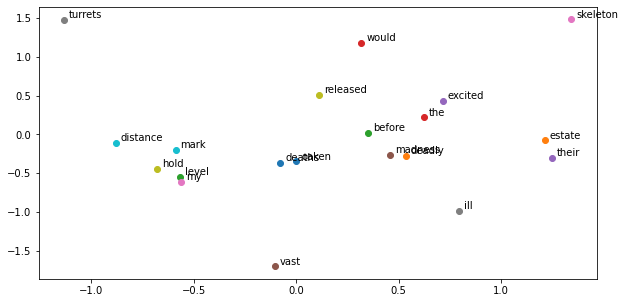

In [23]:
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()

#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(10,5))
for i, word in enumerate(vocabs[:20]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

# Appendix

## Implement with any window_size

In [ ]:
def dataBags(corpus_tokenized):
    # data - [(context), target]
    data = []
    for sent in corpus_tokenized:
        for i in range(2, len(sent) - 2):
            context = [sent[i - 2], sent[i - 1], sent[i + 1], sent[i + 2]]
            target = sent[i]
            data.append((context, target))

    return data

cbow = dataBags(corpus_tokenized)
cbow[:5]

## Example to import db file

In [ ]:
import pandas as pd
import sqlite3
def ReadSQL(filename):
    connection = sqlite3.connect(filename)
    data = pd.read_sql("SELECT * from city_table",connection)
    return data

ReadSQL('./dataset/city.db')
#It doesn't use it